In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import unittest
import pytest

In [2]:
import pandas as pd
import numpy as np
 
 
#from evidently.pipeline.column_mapping import ColumnMapping
 
from evidently.report import Report
from evidently.metric_preset import DataDrift, NumTargetDrift
 
from evidently.test_suite import TestSuite
from evidently.test_preset import DataQuality, DataStability
from evidently.tests import *

In [3]:
spark = SparkSession.builder\
  .appName("Refresh Raw into Icerberg Table") \
  .config("spark.hadoop.fs.s3a.s3guard.ddb.region", "us-west-2")\
  .config("spark.kerberos.access.hadoopFileSystems", "s3a://ps-uat2")\
  .config("spark.jars","/home/cdsw/lib/iceberg-spark-runtime-3.2_2.12-0.13.2.jar") \
  .config("spark.sql.extensions","org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions") \
  .config("spark.sql.catalog.spark_catalog","org.apache.iceberg.spark.SparkSessionCatalog") \
  .config("spark.sql.catalog.spark_catalog.type","hive") \
  .getOrCreate()

#read raw data 
df_proc = spark.sql("SELECT * FROM spark_catalog.default.pump_processed")
df_proc = df_proc.toPandas()

Setting spark.hadoop.yarn.resourcemanager.principal to dciciani


In [4]:
df_proc.iloc[130000]

timestamp         2018-06-30 06:40:00
sensor_00                        -1.0
sensor_02                        37.5
sensor_04                    3.336227
sensor_06                    0.028935
sensor_07                    23.05411
sensor_08                    23.22049
sensor_09                    22.21499
sensor_10                         0.0
sensor_11                         0.0
sensor_51                        -1.0
machine_status                      0
Name: 130000, dtype: object

## model metrics

In [173]:
#model_deployment_crn = "crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/49482f84-894e-4307-aee8-e9990d22d351"
model_deployment_crn = "crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794"

current_timestamp_ms = int(time.time()) * 1000

known_metrics = cdsw.read_metrics(model_deployment_crn=model_deployment_crn,
                                  start_timestamp_ms=0,
                                  end_timestamp_ms=current_timestamp_ms)  

production = pd.io.json.json_normalize(known_metrics["metrics"])
production

,modelDeploymentCrn,modelBuildCrn,modelCrn,startTimeStampMs,endTimeStampMs,predictionUuid,metrics.data.sensor_00,metrics.data.sensor_02,metrics.data.sensor_04,metrics.data.sensor_06,metrics.data.sensor_07,metrics.data.sensor_08,metrics.data.sensor_09,metrics.data.sensor_10,metrics.data.sensor_11,metrics.data.sensor_51,metrics.prediction
0,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/9a65790c-b135-4944-9705-d24903ac5145,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/7ee08632-3e70-4974-a970-c0180812d840,1665424435115,1665424435125,3f327860-b8ac-48fb-867e-cfb0637d8c15,2.455556,51.08507,641.435181,14.5761,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958,1
1,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/9a65790c-b135-4944-9705-d24903ac5145,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/7ee08632-3e70-4974-a970-c0180812d840,1665426121516,1665426121526,a1712727-9709-4d44-aeab-18a0e81e82fb,2.455556,51.08507,641.435181,14.5761,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958,1
2,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/9a65790c-b135-4944-9705-d24903ac5145,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/7ee08632-3e70-4974-a970-c0180812d840,1665423769973,1665423769983,d1672e3e-26cc-4cba-a4bb-d1690edf3545,2.455556,51.08507,641.435181,14.5761,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958,1
3,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/9a65790c-b135-4944-9705-d24903ac5145,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/7ee08632-3e70-4974-a970-c0180812d840,1665424257290,1665424257301,0f564abb-3d2a-4c5c-b4e3-e89ab810e4fe,2.455556,51.08507,641.435181,14.5761,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958,1
4,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/9a65790c-b135-4944-9705-d24903ac5145,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/7ee08632-3e70-4974-a970-c0180812d840,1665423621904,1665423621915,d3bc3493-4068-4d2e-9bf6-cb3f0514b3c1,2.455556,51.08507,641.435181,14.5761,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958,1
5,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/9a65790c-b135-4944-9705-d24903ac5145,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/7ee08632-3e70-4974-a970-c0180812d840,1665414043669,1665414043755,dcb0f3c7-6fc7-4fa3-a7f2-ff8dd72eecf6,4219,31294,421,645,664,7654,12,1321,3124,643,1
6,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794,crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-31

### monitoring post 

In [142]:
import pandas as pd
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.report import Report
#from evidently.metric_preset import DataDrift, NumTargetDrift, Cat

from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab

from evidently.test_suite import TestSuite
from evidently.test_preset import DataQuality, DataStability 
from evidently.tests import *

import mlflow

path_processed = "/home/cdsw/data/pump_processed.csv"

df = pd.read_csv(path_processed)
df['target'] = df['machine_status']
df = df.drop(["machine_status"], axis=1)
df.head()

,timestamp,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,target
0,2018-04-01 00:00:00,2.465394,53.2118,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,201.3889,1
1,2018-04-01 00:01:00,2.465394,53.2118,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,201.3889,1
2,2018-04-01 00:02:00,2.444734,53.2118,638.8889,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,203.7037,1
3,2018-04-01 00:03:00,2.460474,53.1684,628.1250,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,203.1250,1
4,2018-04-01 00:04:00,2.445718,53.2118,636.4583,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,201.3889,1


In [143]:
period = "2018-08-01 00:00:00"
reference = df.loc[df.timestamp < period].drop("timestamp",axis=1).sample(5000, random_state=0)
target = df.loc[df.timestamp >= period].drop("timestamp",axis=1).sample(5000, random_state=0)

In [144]:
reference

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,target
47296,2.453588,52.256940,643.6343,13.38252,16.42795,15.26331,14.82205,40.18721,47.26311,181.1343,1
4234,2.485070,52.473960,627.8935,13.30295,16.70284,15.85648,15.05353,40.68262,44.56194,209.4907,1
110346,2.503762,51.432289,640.8564,13.64294,16.07350,14.91609,14.74971,41.75233,34.38781,214.6991,1
96577,2.509664,52.126740,638.4259,13.56337,15.62500,15.53096,15.11863,45.87466,35.94968,182.0023,1
79988,2.445718,52.734370,629.3981,13.68634,16.03009,15.29224,15.11863,51.13341,33.16643,242.1875,1
...,...,...,...,...,...,...,...,...,...,...,...
154871,2.512616,50.000000,642.3611,14.60503,16.20370,15.56713,15.08247,47.40725,47.84417,188.3681,1
85914,2.459491,54.340270,622.8009,13.17274,16.21094,15.18374,15.08247,43.68761,40.20554,212.3843,1
124267,2.303067,49.522570,609.7222,13.60677,15.65393,14.91609,14.67737,37.88455,41.63232,-1.0000,1
142330,2.401447,52.387150,631.1343,14.09867,15.70457,15.18374,15.01013,43.92540,44.15007,197.3380,1


In [145]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 191601 to 215817
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sensor_00  5000 non-null   float64
 1   sensor_02  5000 non-null   float64
 2   sensor_04  5000 non-null   float64
 3   sensor_06  5000 non-null   float64
 4   sensor_07  5000 non-null   float64
 5   sensor_08  5000 non-null   float64
 6   sensor_09  5000 non-null   float64
 7   sensor_10  5000 non-null   float64
 8   sensor_11  5000 non-null   float64
 9   sensor_51  5000 non-null   float64
 10  target     5000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 468.8 KB


In [146]:
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, CatTargetDriftProfileSection

In [147]:
numerical_features = ['sensor_00','sensor_02', 'sensor_04', 'sensor_06',  'sensor_07', 'sensor_08',
                     'sensor_09', 'sensor_10', 'sensor_11', 'sensor_51']

categorical_features = ["target"]

In [148]:
column_mapping = ColumnMapping()

column_mapping.target = 'target'
column_mapping.numerical_features = numerical_features


In [157]:
### check target drift profle
pump_target_drift_profile = Profile(sections=[CatTargetDriftProfileSection()])
pump_target_drift_profile.calculate(reference, target, column_mapping=column_mapping) 
json.loads(pump_target_drift_profile.json())["cat_target_drift"]

{'name': 'cat_target_drift',
 'datetime': '2022-10-10 19:36:18.755949',
 'data': {'utility_columns': {'date': None,
   'id': None,
   'target': 'target',
   'prediction': None},
  'cat_feature_names': [],
  'num_feature_names': ['sensor_00',
   'sensor_02',
   'sensor_04',
   'sensor_06',
   'sensor_07',
   'sensor_08',
   'sensor_09',
   'sensor_10',
   'sensor_11',
   'sensor_51'],
  'datetime_feature_names': [],
  'target_names': None,
  'metrics': {'target_name': 'target',
   'target_type': 'cat',
   'target_drift': 0.1741505884033314}}}

In [169]:
### check data drift profile
pump_data_drift_profile = Profile(sections=[DataDriftProfileSection()])
pump_data_drift_profile.calculate(reference, target, column_mapping=column_mapping) 
#json.loads(pump_data_drift_profile.json())['data_drift']['data']['metrics']['dataset_drift']

#json.loads(pump_data_drift_profile.json())['data_drift']['data']['metrics']
s_list = json.loads(pump_data_drift_profile.json())['data_drift']['data']['num_feature_names']
s_dict = {}

for s in s_list:
    score = json.loads(pump_data_drift_profile.json())['data_drift']['data']['metrics'][s]['drift_score']
    s_dict[s] = score    
#s_dict


    

0.34114077776512136
0.36144691438773957
0.34693615067741856
0.6392805898244504
0.36876713001933165
0.34726850739592796
0.28024452462869054
0.33056703780992963
0.7406297732453629
0.4351529579218981


{'sensor_00': 0.34114077776512136,
 'sensor_02': 0.36144691438773957,
 'sensor_04': 0.34693615067741856,
 'sensor_06': 0.6392805898244504,
 'sensor_07': 0.36876713001933165,
 'sensor_08': 0.34726850739592796,
 'sensor_09': 0.28024452462869054,
 'sensor_10': 0.33056703780992963,
 'sensor_11': 0.7406297732453629,
 'sensor_51': 0.4351529579218981}

## read prediction metrics

In [150]:
import cdsw, time, os

model_deployment_crn = ""

In [152]:
current_timestamp_ms = int(time.time()) * 1000

known_metrics = cdsw.read_metrics(model_deployment_crn=model_deployment_crn,
            start_timestamp_ms=0,
            end_timestamp_ms=current_timestamp_ms)  

df = pd.io.json.json_normalize(known_metrics["metrics"])
df.columns


RuntimeError: Response_status_code: '400' , response_body: {"error":"Either model CRN, model deployment CRN or model build CRN must be provided"} 

In [153]:
colums_mapping = {'metrics.data.sensor_00': 'sensor_00',
                  'metrics.data.sensor_02': 'sensor_02',
                  'metrics.data.sensor_04': 'sensor_04',
                  'metrics.data.sensor_06': 'sensor_06',
                  'metrics.data.sensor_07': 'sensor_07',
                  'metrics.data.sensor_08': 'sensor_08',
                  'metrics.data.sensor_09': 'sensor_09',
                  'metrics.data.sensor_10': 'sensor_10',
                  'metrics.data.sensor_11': 'sensor_11',
                  'metrics.data.sensor_51': 'sensor_51',
                  'metrics.prediction' : 'target'
                 }
df.rename(columns=colums_mapping, inplace=True)


In [154]:
df.head()

,timestamp,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,target
0,2018-04-01 00:00:00,2.465394,53.2118,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,201.3889,1
1,2018-04-01 00:01:00,2.465394,53.2118,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,201.3889,1
2,2018-04-01 00:02:00,2.444734,53.2118,638.8889,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,203.7037,1
3,2018-04-01 00:03:00,2.460474,53.1684,628.1250,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,203.1250,1
4,2018-04-01 00:04:00,2.445718,53.2118,636.4583,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,201.3889,1


In [11]:
# drop unused colums
cols_to_keep = ['sensor_00', 'sensor_02', 'sensor_04', 'sensor_06', 'sensor_07', 
                'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_51']
df = df[cols_to_keep]

# cast sensors value to numeric

df[cols_to_keep] = df[cols_to_keep].astype(float)

df

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51
0,4219.000000,31294.00000,421.000000,645.0000,664.00000,7654.00000,12.00000,1321.00000,3124.00000,643.0000
1,2.455556,51.08507,641.435181,14.5761,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958


In [8]:
cols_to_keep = ['sensor_00', 'sensor_02', 'sensor_04', 'sensor_06', 'sensor_07', 
                'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_51', 'target']


cols_to_keep

['sensor_00',
 'sensor_02',
 'sensor_04',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_51',
 'target']

In [10]:
cols_to_keep.remove('target')
print(cols_sensors)

ValueError: list.remove(x): x not in list

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sensor_00  1 non-null      object
 1   sensor_02  1 non-null      object
 2   sensor_04  1 non-null      object
 3   sensor_06  1 non-null      object
 4   sensor_07  1 non-null      object
 5   sensor_08  1 non-null      object
 6   sensor_09  1 non-null      object
 7   sensor_10  1 non-null      object
 8   sensor_11  1 non-null      object
 9   sensor_51  1 non-null      object
dtypes: object(10)
memory usage: 208.0+ bytes


### SIMULATE preds

In [135]:
import requests
import sys
import json
import pandas as pd
import cdsw, time, os

path_processed = "/home/cdsw/data/pump_processed.csv"
df = pd.read_csv(path_processed)
df = df.drop(["machine_status"], axis=1)

filter_period = "2018-08-01 00:00:00"
#filter_period = sys.argv[1] if len(sys.argv) > 1 else None

df_new = df.loc[df.timestamp >= filter_period].drop("timestamp", axis=1)
print("Len df_new: {}".format(len(df_new)))


df_new

Len df_new: 44640


,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51
175680,2.455556,51.085070,641.435181,14.57610,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958
175681,2.455556,51.085070,641.435181,14.57610,16.24711,15.65393,15.16204,48.44366,44.11775,184.8958
175682,2.449653,50.998260,654.282410,14.60503,16.24711,15.56713,15.11863,49.04697,43.99090,185.1852
175683,2.455556,50.998260,641.898132,14.64120,16.13136,15.61777,15.08247,49.35575,45.47868,187.2106
175684,2.454572,50.954860,635.300903,14.59057,16.13136,15.65393,14.97396,49.36914,44.70626,189.5255
...,...,...,...,...,...,...,...,...,...,...
220315,2.407350,50.520830,634.722229,15.11863,16.65220,15.65393,15.16204,43.17085,54.16052,231.1921
220316,2.400463,50.564240,630.902771,15.15480,16.70284,15.65393,15.11863,43.21038,54.52602,231.1921
220317,2.396528,50.520830,625.925903,15.08970,16.70284,15.69734,15.11863,43.12836,55.11779,232.0602
220318,2.406366,50.520832,635.648100,15.11863,16.56539,15.74074,15.11863,42.35746,55.99321,234.0856


In [136]:
import json
pd.set_option('display.max_colwidth', -1)

def call_model_endpoint(x):
    curr_row = x.to_json()
    #print(curr_row)
    #print(values)
    r = requests.post('https://modelservice.ml-1096e3e8-eda.ps-sandb.a465-9q4k.cloudera.site/model', 
                       data='{"accessKey":"m737t61ml4ftqiw609oxdus35yt11ucq","request": ' + curr_row + '}',
                       headers={'Content-Type': 'application/json'})
    
    return r.status_code

#df_new.apply(lambda x: call_model_endpoint(x), axis=1)

175680    200
175681    200
175682    200
175683    200
175684    200
         ... 
220315    200
220316    200
220317    200
220318    200
220319    200
Length: 44640, dtype: int64

In [137]:
# get all rows as json


In [141]:
model_deployment_crn = "crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/49482f84-894e-4307-aee8-e9990d22d351"
#model_deployment_crn = "crn:cdp:ml:us-west-1:558bc1d2-8867-4357-8524-311d51259233:workspace:de20f039-2b2a-48ea-b388-1be9ffd49da1/492d014a-d103-4f7e-a8f7-ca8cb4509794"
current_timestamp_ms = int(time.time()) * 1000

known_metrics = cdsw.read_metrics(model_deployment_crn=model_deployment_crn,
            start_timestamp_ms=0,
            end_timestamp_ms=current_timestamp_ms)  

df = pd.io.json.json_normalize(known_metrics["metrics"])
df

RuntimeError: Response_status_code: '502' , response_body: Bad Gateway 

In [122]:
values = "{\"sensor_00\":2.455556,\"sensor_02\":51.08507,\"sensor_04\":641.4351806641,\"sensor_06\":14.5761,\"sensor_07\":16.24711,\"sensor_08\":15.65393,\"sensor_09\":15.16204,\"sensor_10\":48.44366,\"sensor_11\":44.11775,\"sensor_51\":184.8958}"
values

'{"sensor_00":2.455556,"sensor_02":51.08507,"sensor_04":641.4351806641,"sensor_06":14.5761,"sensor_07":16.24711,"sensor_08":15.65393,"sensor_09":15.16204,"sensor_10":48.44366,"sensor_11":44.11775,"sensor_51":184.8958}'

In [61]:
r.status_code

200

## Data Stability Tests

In [235]:
## Data Drift test
reference = df_raw.sample(n=5000, replace=False)
current = df_raw.sample(n=5000, replace=False)

data_stability = TestSuite(tests=[
    DataStability(),
])
data_stability.run(reference_data=reference, current_data=current)

In [ ]:
data_stability.save_html("../reports/data_test.html")

In [234]:
# data drift report
drift_report = Report(metrics=[DataDrift(), NumTargetDrift()])
drift_report.run(reference_data=reference, current_data=current)

NameError: name 'current' is not defined

In [ ]:
drift_report.save_html("../reports/data_drift.html")

In [ ]:
## custom test suite
tests = TestSuite(tests=[
    TestNumberOfColumnsWithNulls(),
    TestNumberOfRowsWithNulls(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedFeatures(), 
])


In [ ]:
tests.run(reference_data=reference, current_data=current)

In [ ]:
tests.save_html("../reports/custom_test_drift.html")

In [145]:
import json

tests_json = json.loads(data_stability.json())

NameError: name 'data_stability' is not defined

In [ ]:
tests_json['summary']['all_passed']

In [ ]:
# get is the dataset has drift
data_drift_json = json.loads(drift_report.json())
data_drift_json['metrics']['DataDriftMetrics']['dataset_drift']

## Time Travel

In [ ]:
from datetime import datetime

# current date and time
now = datetime.now()

timestamp = datetime.timestamp(now)
print("timestamp =", timestamp)

In [ ]:
# query iceberg with a specific time
df_raw = spark.read \
              .option("as-of-timestamp", int(timestamp*1000)) \
              .load("spark_catalog.default.pump_raw")
df.tail(5)

In [ ]:
print(spark.sql("SELECT * FROM spark_catalog.default.pump_processed").count())

In [ ]:
# insert more data into pump_processend

In [ ]:
spark.sql("INSERT INTO spark_catalog.default.pump_processed VALUES (4219, 31294, 42, 645, 664, 7654, 12, 1321, 3124, 643, 0) ")

In [ ]:
 print(spark.sql("SELECT * FROM spark_catalog.default.pump_processed").count())

In [ ]:
## check snapshots
spark.read.format("iceberg").load("spark_catalog.default.pump_raw.history").show(30, False)

In [ ]:
## query a specific snapshot
spark.read\
    .option("snapshot-id", "4884203215810497378")\
    .table("spark_catalog.default.pump_processed").tail(5)


In [ ]:
spark.sql("SELECT * FROM spark_catalog.default.pump_processed.snapshots").show()

In [ ]:
# get current snapshot
spark.read.format("iceberg").load("spark_catalog.default.pump_processed.history").toPandas().iloc[-1]['snapshot_id']

In [ ]:
spark.read\
    .option("snapshot-id", 4884203215810497378)\
    .table("spark_catalog.default.pump_processed").tail(5)


## Explainability SHAP

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [2]:
df_proc = pd.read_csv("../data/pump_sensors_processed.csv")
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208775 entries, 0 to 208774
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       208775 non-null  float64
 1   sensor_02       208775 non-null  float64
 2   sensor_04       208775 non-null  float64
 3   sensor_06       208775 non-null  float64
 4   sensor_07       208775 non-null  float64
 5   sensor_08       208775 non-null  float64
 6   sensor_09       208775 non-null  float64
 7   sensor_10       208775 non-null  float64
 8   sensor_11       208775 non-null  float64
 9   sensor_51       208775 non-null  float64
 10  machine_status  208775 non-null  float64
dtypes: float64(11)
memory usage: 17.5 MB


In [3]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

def normalize_df(df_train, df_test):
    """
    Function to normalize the data using minimax scaler
    """
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(df_train.values)
    scaled_test = scaler.transform(df_test.values)
    train = pd.DataFrame(data=scaled_train, 
                         columns=df_train.columns, 
                         index=df_train.index)
    test = pd.DataFrame(data=scaled_test, 
                        columns=df_test.columns, 
                        index=df_test.index)
    return train, test

In [4]:
# train test split
train_dataPoints = 130000 
train = df_proc[:train_dataPoints]
test = df_proc[train_dataPoints:]

train_x = train.drop(["machine_status"], axis=1)
test_x = test.drop(["machine_status"], axis=1)
train_y = train[["machine_status"]]
test_y = test[["machine_status"]]

train_x, test_x = normalize_df(train_x, test_x)


In [5]:
n_estimators = int(sys.argv[4]) if len(sys.argv) > 4 else 10
max_depth = int(sys.argv[5]) if len(sys.argv) > 4 else 25

# declate rf and fit
rf = RandomForestClassifier(n_estimators=n_estimators, 
                            max_depth=max_depth,
                            criterion='gini', 
                            random_state=21, 
                            n_jobs=-1)
rf.fit(train_x, train_y)

# predict
pred = rf.predict(test_x)

f1_score(test_y, pred, average='macro')


0.9106189762125637

#### Variable Importance Plot

In [20]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(train_x)


In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features=train_x.iloc[0,:])

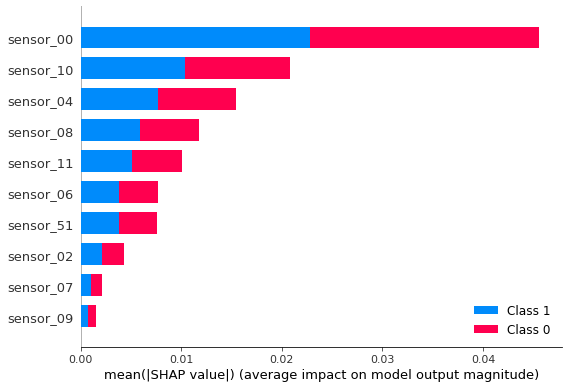

In [27]:
shap.summary_plot(shap_values, features=train_x)

In [76]:
shap.plots.waterfall(shap_values[0])


AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

#### SHAP Dependence Plot — Global Interpretability

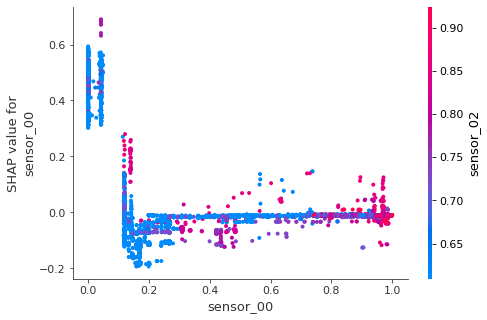

In [46]:
shap.dependence_plot("sensor_00", shap_values[0], train_x)

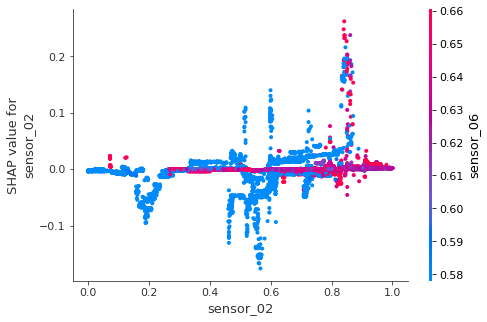

In [47]:
shap.dependence_plot("sensor_02", shap_values[0], train_x)

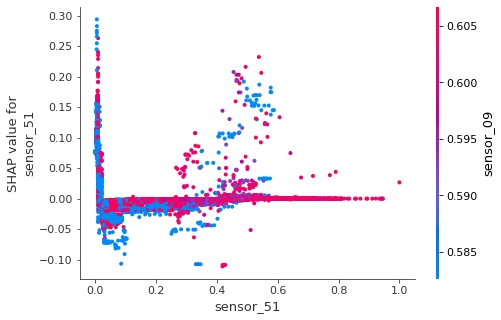

In [48]:
shap.dependence_plot("sensor_51", shap_values[0], train_x)

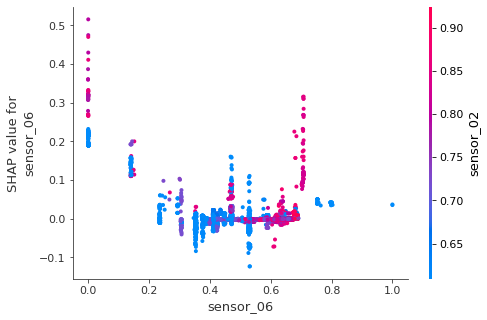

In [49]:
shap.dependence_plot("sensor_06", shap_values[0], train_x)

#### Individual SHAP Value Plot — Local Interpretability

In [52]:
# Get the predictions and put them with the test data.
X_output = test_x.copy()
X_output.loc[:,'predict'] = rf.predict(X_output)

# Randomly pick some observations
#X_output = X_output.sample(1000)

In [ ]:
X_output

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,predict
130000,0.307603,0.812500,0.213514,0.589847,0.578479,0.541344,0.503618,0.179315,0.119882,0.059445,1.0
130001,0.308375,0.812500,0.217144,0.589847,0.578479,0.546401,0.502460,0.174117,0.108951,0.058785,1.0
130002,0.309533,0.812500,0.311539,0.591201,0.578479,0.540452,0.501592,0.170135,0.108721,0.058124,1.0
130003,0.309533,0.812500,0.466443,0.588494,0.577560,0.538370,0.503329,0.172316,0.111462,0.057464,1.0
130004,0.308375,0.812500,0.464236,0.587817,0.576027,0.540452,0.503329,0.174777,0.120523,0.056143,1.0
...,...,...,...,...,...,...,...,...,...,...,...
208770,0.943265,0.751953,0.782950,0.706599,0.703863,0.642474,0.602315,0.523122,0.829767,0.400925,1.0
208771,0.943265,0.753906,0.794616,0.705245,0.707848,0.645747,0.603184,0.528645,0.828345,0.400925,1.0
208772,0.941721,0.751953,0.769594,0.706599,0.705702,0.647234,0.602026,0.602409,0.841808,0.397622,1.0
208773,0.943265,0.753906,0.783821,0.706599,0.703863,0.647234,0.598842,0.555873,0.870031,0.394320,1.0


In [67]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [53]:
a = X_output.iloc[0:10]

In [54]:
explainerModel = shap.TreeExplainer(rf)
shap_values_a= explainerModel.shap_values(a)

In [55]:
a

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,predict
130000,0.307603,0.812500,0.213514,0.589847,0.578479,0.541344,0.503618,0.179315,0.119882,0.059445,1.0
130001,0.308375,0.812500,0.217144,0.589847,0.578479,0.546401,0.502460,0.174117,0.108951,0.058785,1.0
130002,0.309533,0.812500,0.311539,0.591201,0.578479,0.540452,0.501592,0.170135,0.108721,0.058124,1.0
130003,0.309533,0.812500,0.466443,0.588494,0.577560,0.538370,0.503329,0.172316,0.111462,0.057464,1.0
130004,0.308375,0.812500,0.464236,0.587817,0.576027,0.540452,0.503329,0.174777,0.120523,0.056143,1.0
130005,0.307603,0.810546,0.480308,0.589847,0.578479,0.544914,0.503618,0.179790,0.143060,0.055482,1.0
130006,0.309147,0.810547,0.459252,0.583756,0.582465,0.539262,0.502171,0.183688,0.124747,0.054822,1.0
130007,0.310691,0.810547,0.479622,0.591201,0.577560,0.540155,0.501881,0.183196,0.113776,0.052840,1.0
130008,0.310691,0.810546,0.481353,0.588494,0.576027,0.553837,0.502460,0.188444,0.117101,0.052180,1.0
130009,0.308375,0.806640,0.493077,0.589847,0.576027,0.549673,0.504486,0.196468,0.122993,0.051519,1.0


In [56]:
shap.force_plot(explainerModel.expected_value[0], shap_values_a[0][0], a.iloc[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'